github repo: https://github.com/zheyanliu99/data-mining-hw3.git

# Problem 2

In [1]:
import numpy as np
from utils import random_normal_with_chi
from scipy.stats import chi2

## b) & c)

Generate data using random_normal_with_chi in utils.py

In [2]:
X, y = random_normal_with_chi((2000, 10), chi2.ppf(q=0.5, df=10))
X_test, y_test = random_normal_with_chi((20000, 10), chi2.ppf(q=0.5, df=10))

Fit AdaBoost

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
train_final_loss = 1 - clf.score(X, y)
test_final_loss = 1 - clf.score(X_test, y_test)
train_error_steps = [ 1-a for a in list(clf.staged_score(X, y))]
test_error_steps = [ 1-a for a in list(clf.staged_score(X_test, y_test))]

Plot errors of each iter

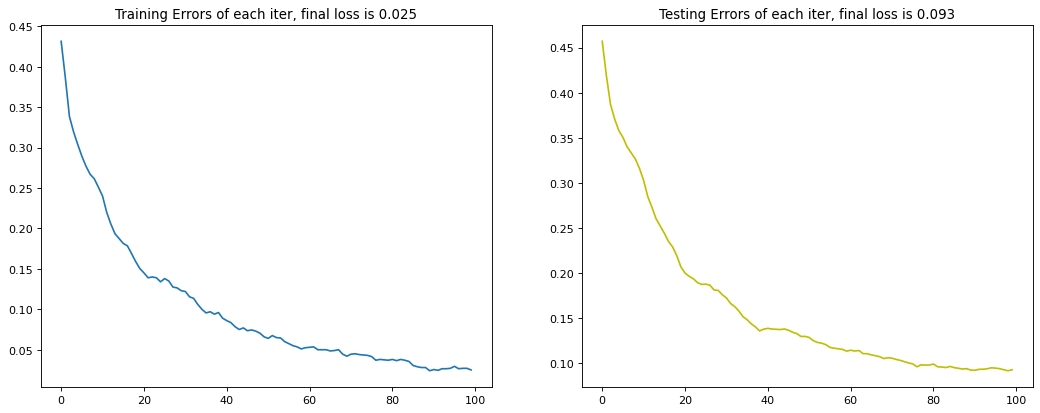

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6), dpi=80)
plt.subplot(1,2,1)
plt.plot(train_error_steps)
plt.title(f"Training Errors of each iter, final loss is {np.round(train_final_loss, 3)}")
plt.subplot(1,2,2)
plt.plot(test_error_steps, 'y')
plt.title(f"Testing Errors of each iter, final loss is {np.round(test_final_loss, 3)}")
plt.show()

The training and testing error decrease as the increase of iter. After iter 20, the errors decrease much slower.

## d)

Class 2

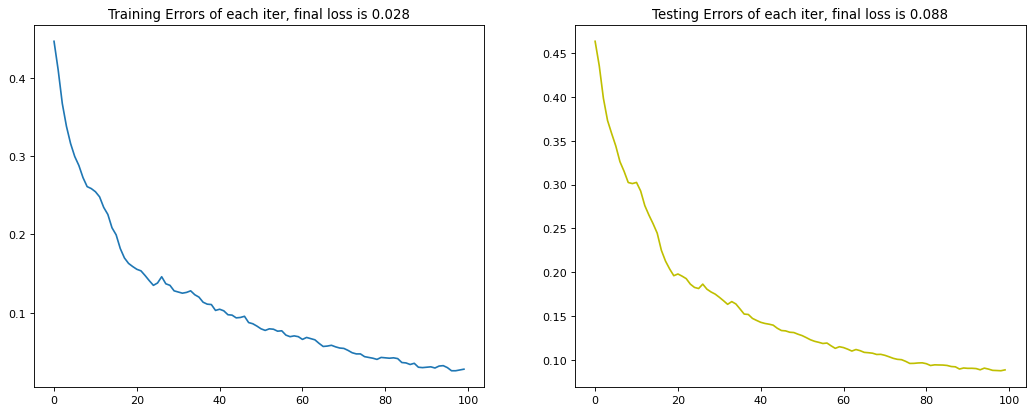

In [5]:
X, y = random_normal_with_chi((2000, 10), 12)
X_test, y_test = random_normal_with_chi((20000, 10), 12)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
train_final_loss = 1 - clf.score(X, y)
test_final_loss = 1 - clf.score(X_test, y_test)
train_error_steps = [ 1-a for a in list(clf.staged_score(X, y))]
test_error_steps = [ 1-a for a in list(clf.staged_score(X_test, y_test))]

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6), dpi=80)
plt.subplot(1,2,1)
plt.plot(train_error_steps)
plt.title(f"Training Errors of each iter, final loss is {np.round(train_final_loss, 3)}")
plt.subplot(1,2,2)
plt.plot(test_error_steps, 'y')
plt.title(f"Testing Errors of each iter, final loss is {np.round(test_final_loss, 3)}")
plt.show()

Compared with Class 1, Class 2 final loss are lower on both the train and test set.

# Problem 3

Read and split data to train and test

## Data and model preparation

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('static/spam.csv')
X = df.drop('y',axis=1)
y = df['y']
X_train = df[df['if_test']==0].drop(['y','if_test'], axis=1)
X_test = df[df['if_test']==1].drop(['y','if_test'], axis=1)
y_train = df[df['if_test']==0]['y']
y_test = df[df['if_test']==1]['y']
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

Standardlize data

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

Data loader

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(X_train, y_train)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

Neural Network for classification

In [25]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

# hyper parameters
learning_rate = 0.05
epochs = 90
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

## Training

In [26]:
from sklearn.metrics import accuracy_score

losses = []
accur = []
for i in range(epochs):
  for j,(x_train_batch,y_train_batch) in enumerate(trainloader):
    
    #calculate output
    output = model(x_train_batch)
 
    #calculate loss
    loss = loss_fn(output,y_train_batch.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(X_train,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%5 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.46345362067222595	 accuracy : 0.6026101141924959
epoch 5	loss : 0.08540032058954239	 accuracy : 0.8897226753670473
epoch 10	loss : 0.0403367355465889	 accuracy : 0.9132137030995106
epoch 15	loss : 0.02539150044322014	 accuracy : 0.9181076672104405
epoch 20	loss : 0.019356153905391693	 accuracy : 0.9200652528548124
epoch 25	loss : 0.01696646586060524	 accuracy : 0.9252854812398043
epoch 30	loss : 0.016002560034394264	 accuracy : 0.9262642740619902
epoch 35	loss : 0.015358109958469868	 accuracy : 0.9278955954323002
epoch 40	loss : 0.014199179597198963	 accuracy : 0.9295269168026101
epoch 45	loss : 0.01326681673526764	 accuracy : 0.9282218597063622
epoch 50	loss : 0.012770192697644234	 accuracy : 0.9298531810766721
epoch 55	loss : 0.011570424772799015	 accuracy : 0.9308319738988581
epoch 60	loss : 0.010393699631094933	 accuracy : 0.931810766721044
epoch 65	loss : 0.009534898214042187	 accuracy : 0.935399673735726
epoch 70	loss : 0.008363761007785797	 accuracy : 0.93507340

## Testing

In [27]:
from sklearn import metrics
X_test = sc.fit_transform(X_test)
predicted = model(torch.tensor(X_test,dtype=torch.float32))
predicted_np = predicted.reshape(-1).detach().numpy()

acc = (predicted_np.round() == y_test).mean()
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_np)
auc_score = metrics.auc(fpr, tpr)
print("Accuracy {} AUC : {}".format(acc,auc_score,acc))

Accuracy 0.9127604166666666 AUC : 0.9785218657069629


## Result

The performance of NN on the test set is better than tree in terms of AUC. However, the interpretability of the tree is much better.